<a href="https://colab.research.google.com/github/rdemarqui/llm_complaint_management/blob/main/02.%20LLM_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM at Work: Decoding Customer Feedback

This study aims to explore these technological advancements, specifically using the advanced LLM tool Mistral 7B, to analyze a vast collection of complaints gathered from the website [reclameaqui.com.br](reclameaqui.com.br). Through this analysis, we intend to demonstrate the potential and effectiveness of LLMs in interpreting and handling large-scale user feedback.

For more information, please visit my github page: https://github.com/rdemarqui/llm_complaint_management

## Complaint Dataset

### Load

In [37]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [16]:
# Loading data
data_url = 'https://raw.githubusercontent.com/rdemarqui/llm_complaint_management/main/datasets/full_dataset_claro.xlsx'
df = pd.read_excel(data_url, usecols=['problem', 'description'])
print(df.shape)

(7000, 2)


### Clean

In [17]:
# Remove extra space and uncase all words
df['description'] = df['description'].astype(str)
df['description'] = df['description'].str.replace(r'\s{2,}', ' ', regex=True)
df['description'] = df['description'].str.lower()

,problem,description
0,Cobrança indevida,recebi um e-mail spam com uma fatura no valor ...
1,Cobrança indevida,"compra não autoriza na meu cartão, chip de núm..."
2,Cobrança indevida,no dia 11 de outubro realizei uma recarga pelo...
3,Cobrança indevida,segue o número de protocolo do atendimento rea...
4,Cobrança indevida,fiz hoje dia 12/10/2023 uma recarga de celular...


In [19]:
# Modify mask made by reclame aqui
def remove_mask(text):
  return text.replace("[Editado pelo Reclame Aqui]", "[mask]")

df['description'] = df['description'].apply(remove_mask)

### Analysis

In [20]:
# Show each problem category
df['problem'].value_counts()

Cobrança indevida                          500
Planos e tarifas                           500
Cancelamento                               500
Portabilidade                              500
Corte indevido da linha                    500
Mudança de plano                           500
Mau atendimento do prestador de serviço    500
Consumo de crédito                         500
Problemas com o chip                       500
Promoções                                  500
Qualidade da internet                      500
Problema com recarga                       500
Demora na execução                         500
Instabilidade do sinal                     500
Name: problem, dtype: int64

In [21]:
# Show statistics of words
df['word_count'] = df['description'].str.split().str.len()
df['text_len'] = df['description'].str.len()
df['word_count'].describe()

count    7000.000000
mean      114.687857
std        93.247534
min         1.000000
25%        54.000000
50%        89.000000
75%       146.000000
max      1021.000000
Name: word_count, dtype: float64

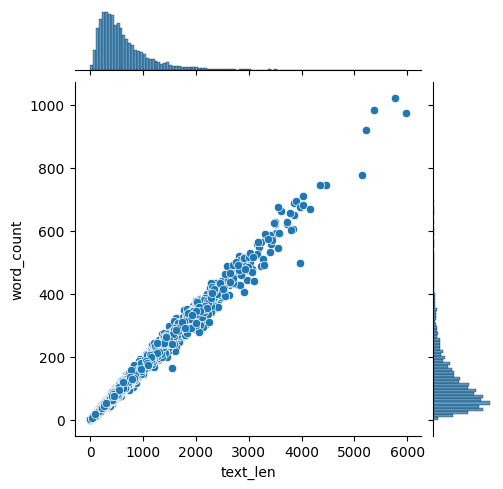

In [22]:
# Check correlation between word count and text lenght
sns.jointplot(data=df, x="text_len", y="word_count", height=5);

In [23]:
# Check word median per category
df.groupby('problem')['word_count'].median()

problem
Cancelamento                                95.0
Cobrança indevida                          103.5
Consumo de crédito                          86.0
Corte indevido da linha                    100.0
Demora na execução                          85.0
Instabilidade do sinal                      74.5
Mau atendimento do prestador de serviço     97.5
Mudança de plano                           103.5
Planos e tarifas                            99.0
Portabilidade                              106.0
Problema com recarga                        71.5
Problemas com o chip                        93.0
Promoções                                   66.0
Qualidade da internet                       71.5
Name: word_count, dtype: float64

## Text Classification

### Loading Model

There are several 7B models available as open source, such as Mistral, Falcon, Zephyr, and Openchat. In this study we will use Mistral, but other models can also be tested, just paying attention to adapting the instruction structure.

In [24]:
import time
from datetime import timedelta
from google.colab import files
from IPython.display import clear_output

In [25]:
# Latest HF transformers version for Mistral-like models
!pip install git+https://github.com/huggingface/transformers.git

# GPTQ Dependencies
!pip install optimum
!pip3 install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/  # Use cu117 if on CUDA 11.7

clear_output()

In [26]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

We will use the pre-trained Mistral 7B model, quantized by the user TheBloke and available at https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GPTQ.

For more information on quantization, there is an excellent article written by Maxime Labonne:
* https://towardsdatascience.com/introduction-to-weight-quantization-2494701b9c0c

In [134]:
# Load LLM and Tokenizer
model_id = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=False,
    revision="main"
)
clear_output()

In [135]:
# Create a pipeline
generator = pipeline(model=model,
                tokenizer=tokenizer,
                task='text-generation',
                max_new_tokens=50,
                temperature=0.20,
                do_sample=True
                )
clear_output()

### Prompt Engineering

Prompt Guide:
* https://www.promptingguide.ai/models/mistral-7b

In [136]:
few_shot = """
<s>
[INST]
Reclamação: A cobertura é ruim. Minha fatura está incorreta!
Classifique a reclamação acima.
[/INST] sinal/conexão de rede; cobrança indevida
[INST]
Reclamação: Recebo muitas mensagens de propaganda. Não consigo falar com a atendente.
Classifique a reclamação acima.
[/INST] spam; atendimento ineficiente
</s>
"""

In [137]:
# This is the footprint of your prompt. This will be replicated in all prompts
prompt_footprint = """[INST]
Reclamação: {user_complain}

Classifique a reclamação baseado em uma ou mais categorias abaixo:
sinal/conexão de rede; cobrança indevida; consumo saldo/crédito; plano/benefício; cancelar linha/plano; recuperar número/linha; chip/sim card; spam; portabilidade; recarga/pagamento; atendimento ineficiente

Atenção use somente as categorias, não explique!
[/INST]"""

In [138]:
# Build the prompt
prompt = few_shot + prompt_footprint
print(prompt)


<s>
[INST]
Reclamação: A cobertura é ruim. Minha fatura está incorreta!
Classifique a reclamação acima.
[/INST] sinal/conexão de rede; cobrança indevida
[INST]
Reclamação: Recebo muitas mensagens de propaganda. Não consigo falar com a atendente.
Classifique a reclamação acima.
[/INST] spam; atendimento ineficiente
</s>
[INST]
Reclamação: {user_complain}

Classifique a reclamação baseado em uma ou mais categorias abaixo:
sinal/conexão de rede; cobrança indevida; consumo saldo/crédito; plano/benefício; cancelar linha/plano; recuperar número/linha; chip/sim card; spam; portabilidade; recarga/pagamento; atendimento ineficiente

Atenção use somente as categorias, não explique!
[/INST]


In [139]:
def llm_analysis(complain):
  response = generator(prompt.format(user_complain=complain))
  llm_classification = response[0]['generated_text'].split('[/INST]')[-1][1:].replace('.', '')

  return llm_classification

In [140]:
# Example
complain ="""
A tempos recebo inúmeras ligações da Claro, para adquirir planos de telefonia pós pago. Atualmente utilizo o serviço pré pago da operadora, o que para mim já é viável e já atendi inúmeras vezes informando que não tenho interesse em fazer plano. Alguns dos números que iniciam em 03037 e outros que não adianta nem adicionar em spam, não têm hora e nem dia, é desagradável a quantidade de ligações e insistência da operadora. Fiz a mudança devido a finalização da operadora Oi e sobre os serviços sinal e etc não há o que reclamar, porém se nao houver jeito vou ter que mudar pra qualquer outra operadora que não me ligue o tempo todo.
""".lower()

llm_analysis(complain)

'spam; atendimento ineficiente'

### Classification

**Note:** Depending on the amount of data, the classification process can take a few hours. Using the model described above and utilizing the free tier infrastructure of Colab, I noticed that Mistral takes about an hour to classify 2,000 cases.

Colab tends to disconnect due to inactivity. To prevent this, open your browser's inspector, go to the console tab, paste the code below, and press enter.

`function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)`

In [44]:
def iterate_over_interval(df, column, limit_char, start_row, end_row):
  for index in range(start_row, end_row + 1):
    complaint_content = str(df.loc[index, column]).lower()

    # Limit text lengh
    if len(complaint_content) > limit_char: complaint_content = complaint_content[:limit_char]+'\n'

    # Text analysis
    analysis = llm_analysis(complaint_content)
    df.at[index, 'llm_class'] = analysis

  # Save final result
  file_save = 'analise_reclamacao_' + str(start_row) + '_' + str(end_row) + '.xlsx'
  df.to_excel(file_save, index=False)

In [141]:
start_time = time.time()

iterate_over_interval(df=df, column="problem",
                      limit_char=2000,
                      start_row=0, end_row=100)

end_time = time.time()
delta_time = str(timedelta(seconds=end_time - start_time))
print(f"Execution: {delta_time}")

Execution: 0:01:20.360061


## Results

In [142]:
df

,problem,description,word_count,text_len,llm_class
0,Cobrança indevida,recebi um e-mail spam com uma fatura no valor ...,19,105,cobrança indevida
1,Cobrança indevida,"compra não autoriza na meu cartão, chip de núm...",9,57,cobrança indevida
2,Cobrança indevida,no dia 11 de outubro realizei uma recarga pelo...,158,958,cobrança indevida
3,Cobrança indevida,segue o número de protocolo do atendimento rea...,221,1230,cobrança indevida
4,Cobrança indevida,fiz hoje dia 12/10/2023 uma recarga de celular...,176,968,cobrança indevida
...,...,...,...,...,...
6995,Instabilidade do sinal,boa noite ! informo que nos últimos 4meses ven...,131,801,NaN
6996,Instabilidade do sinal,compramos o plano da claro a 7 meses para os n...,75,416,NaN
6997,Instabilidade do sinal,eu consigo ligar para todos os outros números ...,53,297,NaN
6998,Instabilidade do sinal,"foi feito a portabilidade da operadora vivo, p...",95,539,NaN


---